<a href="https://colab.research.google.com/github/Bofan1120/WasterWater/blob/master/IWS_Module1_Fianl_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/gdrive')
os.chdir("/gdrive/My Drive/MLcontent/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [35]:
from pandas import read_csv
from pandas import datetime
from pandas import to_numeric
from pandas import concat
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf

#tf.enable_v2_behavior()
from tensorflow.compat.v1.keras import backend as K
from keras.layers import SimpleRNN, Dense, LSTM, Bidirectional, GRU
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint

import os
import random as rn

import itertools
#from keras import backend as K

print(tf.__version__)

2.3.0


In [3]:
#Setting a seed for the computer's pseudorandom number generator. 
#This allows us to reproduce the results from our script:
#固定seed
n = 5
np.random.seed(100 * n)
rn.seed(10000 * n)


In [4]:
#Depending on the actual running environment, you may specify if using GPU, or only CPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#Tensorflow session configuration.
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

tf.compat.v1.set_random_seed(1000 * n)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [5]:
series = read_csv('Wastewater_Data.csv', header=0, parse_dates=[0], index_col=0,squeeze=True)
series = series.replace('^\s*$', np.nan, regex=True)
series = series.fillna(method='ffill')
series
#series = series.apply(to_numeric)

,Total Solids,SS,BOD5,NH3,Org-N,P-TOT,SO4,TKN,PRCP_NOOA
Date,,,,,,,,,
2001-01-01,984.0,170.0,173,15.93,14.0,4.58,72,29.97,0.00
2001-01-02,924.0,122.0,174,15.52,14.4,4.52,72,29.96,0.00
2001-01-03,1135.0,300.0,303,14.19,21.9,6.06,72,36.11,0.00
2001-01-04,1013.0,192.0,228,15.43,19.4,5.33,72,34.83,0.00
2001-01-05,1088.0,226.0,210,14.77,19.3,5.41,72,34.06,0.00
...,...,...,...,...,...,...,...,...,...
2018-12-27,892.0,264.0,157,12.45,11.1,3.84,85,23.53,0.66
2018-12-28,776.0,104.0,94,10.61,6.2,1.97,85,16.76,0.08
2018-12-29,898.0,148.0,83,11.38,7.4,2.7,85,18.81,0.05


In [6]:
#narmalization
#lag defines how many historical data are used to predict a specific wasterwater characteristic (e.g., BOD5)
lag = 7

#num_features defines how many historical wasterwater characteristics are used. We have 9 in total (i.e., TS, BOD5, NH3, etc.)
num_features = 9

from pandas import DataFrame
from sklearn import preprocessing
names = series.columns
x = series.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled
series_normalized = DataFrame(x_scaled, columns=names)
#The following line of code will do the same normalization as the code above.
#series_normalized = (series - np.min(series))/(np.max(series)-np.min(series))
series_normalized

,Total Solids,SS,BOD5,NH3,Org-N,P-TOT,SO4,TKN,PRCP_NOOA
0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
1,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000
2,0.240081,0.091197,0.107750,0.415789,0.197832,0.164535,0.441441,0.251656,0.000000
3,0.204749,0.056998,0.079395,0.454180,0.175248,0.143314,0.441441,0.242636,0.000000
4,0.226470,0.067764,0.072590,0.433746,0.174345,0.145640,0.441441,0.237209,0.000000
...,...,...,...,...,...,...,...,...,...
6569,0.169708,0.079797,0.052552,0.361920,0.100271,0.100000,0.558559,0.163002,0.096210
6570,0.136114,0.029132,0.028733,0.304954,0.056007,0.045640,0.558559,0.115292,0.011662
6571,0.171445,0.043065,0.024575,0.328793,0.066847,0.066860,0.558559,0.129739,0.007289
6572,0.165653,0.035465,0.031002,0.364706,0.057814,0.059593,0.558559,0.130514,0.000000


In [33]:
# table2lags() Shifts a dataFrame along its time axis (i.e., index) n steps 
# (moving down/up if step is a positive/negative number), determined by min_lag and max_lag, 
# and merge all shiffted dataframes into a single one and return, 
# without including the original DataFrame (the one shifted 0 step).
# "values" is a list, and each item in "values" is a shifted dataframe.
# Input: Table: a DataFrame; max_lag: the maximum shifting; min_lag: the minimum shifting; 
# In this module, no need to include the original dataframe or shift the dataframe up, and thus min_lag = 1 by default
# separator: used to concatenate the step value (e.g., 1, 2, 3) to the original column label. E.g., SO4_1, SO4_2, etc.
# Output: a dataframe
def table2lags(table, max_lag, min_lag=1, separator='_'):
    values = []
    for i in range(min_lag, max_lag + 1):
        #append shiffted dataframe into the list (i.e., values)
        values.append(table.shift(i).copy()) 
        #replace the last item or dataframe's columns by column_n; n is the shift step  
        values[-1].columns = [c + separator + str(i) for c in table.columns] 
    #pandas.concat is used to merge all dataframes (as items in values) into a single dataframe
    return concat(values, axis=1) 

#prepare all historical (e.g., one day ago, two day ago,...) data into one dataframe. 
#For all missing data, replaced by its closest future values

X = table2lags(series_normalized, lag)
X = X.fillna(method='bfill')
X

,Total Solids_1,SS_1,BOD5_1,NH3_1,Org-N_1,P-TOT_1,SO4_1,TKN_1,PRCP_NOOA_1,Total Solids_2,SS_2,BOD5_2,NH3_2,Org-N_2,P-TOT_2,SO4_2,TKN_2,PRCP_NOOA_2,Total Solids_3,SS_3,BOD5_3,NH3_3,Org-N_3,P-TOT_3,SO4_3,TKN_3,PRCP_NOOA_3,Total Solids_4,SS_4,BOD5_4,NH3_4,Org-N_4,P-TOT_4,SO4_4,TKN_4,PRCP_NOOA_4,Total Solids_5,SS_5,BOD5_5,NH3_5,Org-N_5,P-TOT_5,SO4_5,TKN_5,PRCP_NOOA_5,Total Solids_6,SS_6,BOD5_6,NH3_6,Org-N_6,P-TOT_6,SO4_6,TKN_6,PRCP_NOOA_6,Total Solids_7,SS_7,BOD5_7,NH3_7,Org-N_7,P-TOT_7,SO4_7,TKN_7,PRCP_NOOA_7
0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
1,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
2,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
3,0.240081,0.091197,0.107750,0.415789,0.197832,0.164535,0.441441,0.251656,0.000000,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
4,0.204749,0.056998,0.079395,0.454180,0.175248,0.143314,0.441441,0.242636,0.000000,0.240081,0.091197,0.107750,0.415789,0.197832,0.164535,0.441441,0.251656,0.000000,0.178975,0.034832,0.058979,0.456966,0.130081,0.119767,0.441441,0.208316,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.00000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.0,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000,0.196351,0.050032,0.058601,0.469659,0.126468,0.121512,0.441441,0.208386,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6569,0.216044,0.089297,0.067675,0.563467,0.151762,0.152616,0.558559,0.249049,0.000000,0.178396,0.056998,0.059735,0.566873,0.099368,0.114826,0.558559,0.209232,0.000000,0.168549,0.043699,0.050284,0.511455,0.097561,0.102035,0.684685,0.194715,0.000000,0.155807,0.036732,0.040832,0.508669,0.080397,0.082267,0.684685,0.180691,0.00000,0.170287,0.041165,0.043856,0.477399,0.089431,0.100872,0.684685,0.180832,0.0,0.177816,0.03

In [91]:
#Permutation (target and others)
#9*C80*C81*C82*..*C88 == 9 * 256 ==2304
targetList = ["Total Solids",	"SS", 	"BOD5",	"NH3",	"Org-N",	"P-TOT",	"SO4",	"TKN",	"PRCP_NOOA"]
combinationList = []
for target in targetList:
    one = [target]
    combinationList.append(one)
    temp = targetList[:]
    restList = temp.remove(target)
    for i in range(1, len(temp)+1):
      itert = itertools.combinations(temp, i)
      for t in itert:
        t = list(t)
        t.append(target)
        combinationList.append(t)
    
print(len(combinationList))
targetList = []
for data in combinationList:
    targetList.append(data[-1])
print(targetList)

2304
['Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'Total Solids', 'T

In [8]:
#test
targetList = ["Total Solids"]
for name in targetList:
    targetDF = series_normalized[name].to_frame()
    #print(X_test)
    size = int(len(X) * 0.8) #split the data into training set (80%) and validation set
    train = X[0:size]
    train_target = targetDF[0:size]
    test = X[size:len(X)]
    test_target = targetDF[size:len(X)]
    X_train = train.values.reshape(-1, lag, num_features).astype('float32')
    X_test = test.values.reshape(-1, lag, num_features).astype('float32')
    y_test = test_target.values.astype('float32')
X_train


array([[[0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        [0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        [0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        ...,
        [0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        [0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        [0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ]],

       [[0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        [0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        [0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        ...,
        [0.19635099, 0.05003167, 0.05860113, ..., 0.44144145,
         0.20838618, 0.        ],
        [0.1

Epoch 1/17
263/263 [==============================] - 3s 10ms/step - loss: 0.0396 - mae: 0.0396 - val_loss: 0.0306 - val_mae: 0.0306
Epoch 2/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0349 - mae: 0.0349 - val_loss: 0.0306 - val_mae: 0.0306
Epoch 3/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0344 - mae: 0.0344 - val_loss: 0.0315 - val_mae: 0.0315
Epoch 4/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0306 - val_mae: 0.0306
Epoch 5/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0338 - mae: 0.0338 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 6/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0329 - mae: 0.0329 - val_loss: 0.0291 - val_mae: 0.0291
Epoch 7/17
263/263 [==============================] - 2s 7ms/step - loss: 0.0326 - mae: 0.0326 - val_loss: 0.0296 - val_mae: 0.0296
Epoch 8/17
263/263 [==============================] - 2s 7ms/step - loss: 0

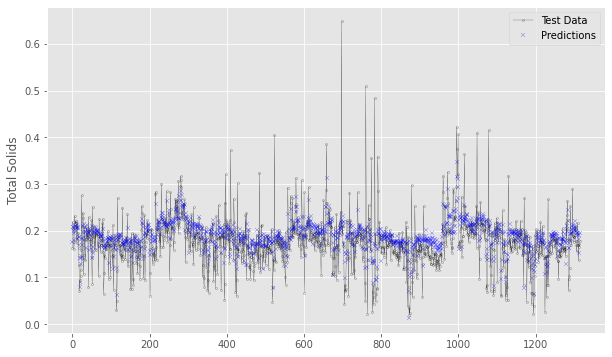

In [54]:
#targetList = ["Total Solids",	"SS", 	"BOD5",	"NH3",	"Org-N",	"P-TOT",	"SO4",	"TKN",	"PRCP_NOOA"]
targetList = ["Total Solids"]
for name in targetList:
    targetDF = series_normalized[name].to_frame()
    #print(X_test)
    size = int(len(X) * 0.8) #split the data into training set (80%) and validation set
    train = X[0:size]
    train_target = targetDF[0:size]
    test = X[size:len(X)]
    test_target = targetDF[size:len(X)]

    X_train = train.values.reshape(-1, lag, num_features).astype('float32')
    y_train = train_target.values.astype('float32')

    X_test = test.values.reshape(-1, lag, num_features).astype('float32')
    y_test = test_target.values.astype('float32')
    
    hidden = 64
    batch_size = 20
    epochs = 17

    #we'll import the Sequential model type from Keras. 
    #This is simply a linear stack of neural network layers, and it's perfect for the type of feed-forward CNN and RNN
    model = Sequential()
    model.add(Bidirectional(LSTM(hidden), input_shape=(lag, num_features)))
    model.add(Dense(1))

    model.compile(optimizer='adam',
                loss='mae',
                metrics=['mae'])

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_test,y_test))

    y_predict = model.predict(X_test)
    plt.style.use("ggplot")

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, color='black', linewidth=.2, marker='o', markersize=2,
                markeredgecolor='black', markeredgewidth=0.2, fillstyle='none')
    plt.plot(y_predict, color='blue', linewidth=4, linestyle=' ', marker='x', markersize=4,
                markeredgecolor='blue', markeredgewidth=.2, fillstyle='none')
    plt.legend(('Test Data', 'Predictions'))
    #plt.savefig(name+".png", dpi = 600)
    plt.ylabel(name)

    plt.show()


In [25]:
val = np.array(history.history['mae'])
val.mean()

0.032882576260496586